In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 21 04:09:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
sys.path.insert(0, '/content/gdrive/MyDrive/thesis_python_scripts')

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime as dt
import math
import warnings

# .py file imports
import Performance_Stats as ps
import Data_Prep as dp
from Loss_Fcn import abs_softmax, sharpe_loss
import Train_Test as TT
from Models import LSTM_port, GRU_port, Transformer_port

warnings.filterwarnings('ignore')

Device: cuda:0
Number of devices: 1
Device: cuda:0
Number of devices: 1
Device: cuda:0
Number of devices: 1
Device: cuda:0
Number of devices: 1
Device: cuda:0
Number of devices: 1


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    n_workers = os.cpu_count()
else:
    n_workers = torch.cuda.device_count()

# If on a CUDA machine, this should print a CUDA device:
print("Device:", device)
print("Number of devices:", n_workers)

Device: cuda:0
Number of devices: 1


In [ ]:
# load data
tickers = pd.read_csv('/content/gdrive/MyDrive/data/_data_vol_tickers')
tickers = list(tickers.iloc[:, 1])
print(len(tickers))

data = pd.read_csv('/content/gdrive/MyDrive/data/_data_set_vol', index_col='date', parse_dates=True)
data = dp.reduce_features(data, ['IvMean90', 'IvMean120', 'ticker'])
pd.options.display.max_columns = None
data.head()

315


IvMean60_A  IvMean360_A  Phv10_A  Phv60_A  IvMeanSkew10_A  \
date                                                                    
2007-11-01      0.3451       0.3224   0.2653   0.1952          0.0475   
2007-11-02      0.3396       0.3256   0.2665   0.1965          0.0452   
2007-11-05      0.3406       0.3267   0.2566   0.1989          0.0866   
2007-11-06      0.3291       0.3249   0.2219   0.1997          0.0188   
2007-11-07      0.3466       0.3294   0.2429   0.2044          0.0155   

            IvMeanSkew60_A  IvMeanSkew360_A  return_A  norm_adjclose_A  \
date                                                                     
2007-11-01          0.0424           0.0170 -0.016271        82.409091   
2007-11-02          0.0722           0.0166 -0.006663        81.863636   
2007-11-05          0.0880           0.0175 -0.009246        81.113636   
2007-11-06          0.0384           0.0155  0.012178        82.113636   
2007-11-07          0.0756           0.0162 -0.029638        79.750000   

            norm_adj_range_pct_A  volume_dollars_MM_A  IvMean60_return_next_A  \
date                                                                            
2007-11-01              0.022634              70.4720               -0.015937   
2007-11-02              0.025309              47.6393                0.002945   
2007-11-05              0.023655              75.8815               -0.033764   
2007-11-06              0.024029              79.4667                0.053175   
2007-11-07              0.031996              75.7568                0.038373   

            IvMean60_return_prev_A  IvMean60_return_ten_next_A  IvMean60_AAP  \
date                                                                           
2007-11-01                     NaN                    0.018835        0.3259   
2007-11-02               -0.015937                   -0.159894        0.3283   
2007-11-05                0.002945                   -0.141809        0.3418   
2007-11-06               -0.033764                   -0.154968        0.3236   
2007-11-07                0.053175                   -0.161858        0.3437   

            IvMean360_AAP  Phv10_AAP  Phv60_AAP  IvMeanSkew10_AAP  \
date                                                                
2007-11-01         0.3312     0.3865     0.3035            0.0302   
2007-11-02         0.3471     0.3352     0.3072            0.0311   
2007-11-05         0.3469     0.3788     0.3155            0.0122   
2007-11-06         0.3457     0.4065     0.3167            0.0354   
2007-11-07         0.3461     0.4091     0.3168            0.0260   

            IvMeanSkew60_AAP  IvMeanSkew360_AAP  return_AAP  \
date                                                          
2007-11-01            0.0307             0.0203    0.026811   
2007-11-02            0.0314             0.0272   -0.008051   
2007-11-05            0.0138             0.0263    0.010526   
2007-11-06            0.0356             0.0403    0.036458   
2007-11-07            0.0266             0.0247   -0.008013   

            norm_adjclose_AAP  norm_adj_range_pct_AAP  volume_dollars_MM_AAP  \
date                                                                           
2007-11-01         255.082845                0.058286               245.0139   
2007-11-02         253.045674                0.036568                90.0410   
2007-11-05         255.737649                0.055003               117.8234   
2007-11-06         265.414209                0.049460                86.2215   
2007-11-07         263.304283                0.022039                73.2562   

            IvMean60_return_next_AAP  IvMean60_return_prev_AAP  \
date                                                             
2007-11-01                  0.007364                       NaN   
2007-11-02                  0.041121                  0.007364   
2007-11-05                 -0.053248                  0.041121   
2007-11-06                  0.06211

In [ ]:
# hyperparam testing LSTM/GRU grid search
torch.manual_seed(109)
iv=60
out_feats = 15
num_sensors = 10 * out_feats
lookback = 30
batch_size = 32
lrs = [0.001, 0.0001, 0.00001]
num_hidden_units = [256, 512, 1024]
epochs = [1, 2, 3]
loss_function = sharpe_loss

params_dict = {'Number Hidden Units':[],
               'Learning Rate':[],
               'Last Train Year':[],
               'Epochs':[],
               'Average Validation Loss':[]}

params_list = [0, 0, 0, 0, 0]
for nhu in num_hidden_units:
    params_list[0] = nhu
    for lr in lrs:
        params_list[1] = lr
        # loop through different time periods
        for i in range(3): # should be 9
            train_year_end = df_train.index[-1].year
            params_list[2] = train_year_end
            t0 = dt.now()
            df_train, df_val, df_test = dp.train_val_test(data, lookback, train_years=5+i) 

            train_dataset = dp.TS_Dataset(df_train, lookback=lookback, iv=iv)
            val_dataset = dp.TS_Dataset(df_val, lookback=lookback, iv=iv)
            test_dataset = dp.TS_Dataset(df_test, lookback=lookback, iv=iv)

            # Should I shuffle data for models with memory? RNN order matters
            train_loader = DataLoader(train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True)

            val_loader = DataLoader(val_dataset,
                                    batch_size=batch_size,
                                    shuffle=False)

            test_loader = DataLoader(test_dataset,
                                     batch_size=batch_size,
                                     shuffle=False)
                

            for epoch in epochs:
                params_list[3] = epoch
                
                model = GRU_port(num_sensors=num_sensors,
                                 hidden_units=nhu,
                                 out_feats=out_feats).to(device)
            
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                train_losses = []
                val_losses = []
                for e in range(epoch):
                    print(f"Epoch {e}\n---------")
                    train_loss = TT.train_model(train_loader, model, loss_function, optimizer=optimizer)
                    train_losses.append(train_loss)
                    val_loss = TT.test_model(val_loader, model, loss_function)
                    val_losses.append(val_loss)
    
                    print('Train loss: {}'.format(train_loss))
                    print('Validation loss: {}'.format(val_loss))
                    print()

                params_list[4] = np.mean(val_losses[-10:])
                for i, key in enumerate(params_dict):
                    params_dict[key].append(params_list[i])
print('Total seconds to train:  {}'.format(T))

In [ ]:
# find best params in params_dict for each year
params_df = pd.DataFrame(params_dict)
train_year = list(params_df['Last Test Year'].unique())
min_loss_index = []
for y in train_year:
    df = params_df[params_df['Last Test Year'] == y].sort_values('Average Validation Loss')
    min_loss_index.append(df.iloc[0].name)
    
min_params_df = params_df.iloc[min_loss_index].sort_values('Last Test Year')
min_params_df


In [ ]:
# test model LSTM/GRU
torch.manual_seed(109)
lr = 0.00001
num_hidden_units = 2048
iv=60
out_feats = 315
num_sensors = 10 * out_feats
lookback = 30
batch_size = 32

min_val_loss = []
time = []

model = LSTM_port(num_sensors=num_sensors,
                 hidden_units=num_hidden_units,
                 out_feats=out_feats).to(device)
loss_function = sharpe_loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# loop through different time periods
df_predictions = pd.DataFrame()
test_losses = []
benchmark_returns = []
benchmark_sharpe = []
portfolio_returns = []
portfolio_sharpe = []
t0 = dt.now()
for i in range(9): # should be 9
    t0 = dt.now()
    df_train, df_val, df_test = dp.train_val_test(data, lookback, train_years=5+i) 

    train_dataset = dp.TS_Dataset(df_train, lookback=lookback, iv=iv)
    val_dataset = dp.TS_Dataset(df_val, lookback=lookback, iv=iv)
    test_dataset = dp.TS_Dataset(df_test, lookback=lookback, iv=iv)

    # Should I shuffle data for models with memory? RNN order matters
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False)

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)


    train_losses = []
    val_losses = []
    for epoch in range(100):
        print(f"Epoch {epoch}\n---------")
        train_loss = TT.train_model(train_loader, model, loss_function, optimizer=optimizer)
        train_losses.append(train_loss)
        val_loss = TT.test_model(val_loader, model, loss_function)
        val_losses.append(val_loss)
    
    
        print('Train loss: {}'.format(train_loss))
        print('Validation loss: {}'.format(val_loss))
        print()
    test_loss = TT.test_model(test_loader, model, loss_function)
    test_losses.append(test_loss)
    
    df_int = TT.get_pred_df_sharpe(df_train,
                                df_test,
                                model=model,
                                batch_size=batch_size,
                                num_assets=315,
                                lookback=lookback,
                                iv=iv,
                                tickers=tickers,
                                test_only=True)
    df_predictions = pd.concat([df_predictions, df_int]).sort_index(ascending=True)
    
    bm_r = ps.total_return(df_int['return_benchmark'][1:])
    bm_s = ps.sharpe_ratio(df_int['return_benchmark'][1:])
    p_r = ps.total_return(df_int['return_portfolio'][1:])
    p_s = ps.sharpe_ratio(df_int['return_portfolio'][1:])
    
    benchmark_returns.append(bm_r)
    benchmark_sharpe.append(bm_s)
    portfolio_returns.append(p_r)
    portfolio_sharpe.append(p_s)
    
    print()
    print('Test loss: {} Portfolio return: {}, Portfolio Sharpe: {}'.format(test_loss, p_r, p_s))
    print('Benchmark return: {}, Benchmark Sharpe: {}'.format(bm_r, bm_s))

t1 = dt.now()
T = (t1 - t0).total_seconds()  
print('Total seconds to train:  {}'.format(T))




Epoch 0
---------
Train loss: 0.015524793851363938
Validation loss: -0.14107637479901314

Epoch 1
---------
Train loss: -0.18607254372909665
Validation loss: -0.07948729768395424

Epoch 2
---------
Train loss: -0.26904599596746265
Validation loss: -0.06490579980891198

Epoch 3
---------
Train loss: -0.4414313891902566
Validation loss: -0.1466331547126174

Epoch 4
---------
Train loss: -0.6428533636033535
Validation loss: -0.14855079911649227

Epoch 5
---------
Train loss: -0.7874840583652258
Validation loss: -0.18309151474386454

Epoch 6
---------
Train loss: -0.9120930448174477
Validation loss: -0.1515309156384319

Epoch 7
---------
Train loss: -1.034824411571026
Validation loss: -0.1380677765700966

Epoch 8
---------
Train loss: -1.1631515987217427
Validation loss: -0.20179458893835545

Epoch 9
---------
Train loss: -1.388530045747757
Validation loss: -0.17919938662089407

Epoch 10
---------
Train loss: -1.446155321598053
Validation loss: -0.21060937829315662

Epoch 11
---------
Trai

In [ ]:
print(np.mean(portfolio_returns),
      np.mean(portfolio_sharpe),
      np.mean(benchmark_returns),
      np.mean(benchmark_sharpe))

0.3915093639442209 5.104333616305608 0.28789521784296135 0.4989033897375529


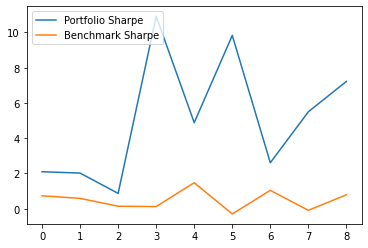

In [ ]:
#TT.plot_returns(portfolio_returns, benchmark_returns)
TT.plot_returns(portfolio_sharpe, benchmark_sharpe, returns=False)

In [ ]:
x = df_predictions
x.to_csv(path_or_buf='/content/gdrive/MyDrive/data/output_lstm_df_0206_1.csv')

In [ ]:
# hyperparam testing Attn grid search
# what do I want to run through?
# definite: lr, dim_val, n_heads, epochs 3*3*3*3...but lets run this 3*3 then 3*3 for total of 18 instead of 81
## Attn Model parameters
torch.manual_seed(109)
n_decoder_layers = 2 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
input_size = 3150 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 30 # length of input given to decoder. Can have any integer value.
enc_seq_len = 30 # length of input given to encoder. Can have any integer value.
output_sequence_length = 1 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make\ the positional encoder
num_predicted_features = 315
dim_vals = [1024, 2048, 4096] # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = [4, 8] # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number

# Other Params
batch_size = 32
loss_function = sharpe_loss
lookback=30
iv=60
lrs = [0.00001]
epochs = [100]

params_dict = {'Dim_Vals':[],
               'N_Heads': [],
               'Learning_Rate':[],
               'Last_Train_Year':[],
               'Epochs':[],
               'Average_Validation_Loss':[]}

params_list = [0, 0, 0, 0, 0, 0]
for dv in dim_vals:
    params_list[0] = dv
    for nh in n_heads:
        params_list[1] = nh
        for lr in lrs:
            params_list[2] = lr
            # loop through different time periods
            for i in range(9):
                t0 = dt.now()
                df_train, df_val, df_test = dp.train_val_test(data, lookback, train_years=5+i) 

                train_year_end = df_train.index[-1].year
                params_list[3] = train_year_end

                train_dataset = dp.TS_Dataset_attn(df_train, lookback=lookback, iv=iv)
                val_dataset = dp.TS_Dataset_attn(df_val, lookback=lookback, iv=iv)
                test_dataset = dp.TS_Dataset_attn(df_test, lookback=lookback, iv=iv)

                # Should I shuffle data for models with memory? RNN order matters
                train_loader = DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

                val_loader = DataLoader(val_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)

                test_loader = DataLoader(test_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

                for epoch in epochs:
                    params_list[4] = epoch
                
                    model = Transformer_port(
                        batch_first=True,
                        dim_val=dv,
                        input_size=input_size, 
                        dec_seq_len=dec_seq_len,
                        max_seq_len=max_seq_len,
                        out_seq_len=output_sequence_length, 
                        n_decoder_layers=n_decoder_layers,
                        n_encoder_layers=n_encoder_layers,
                        n_heads=nh, 
                        num_predicted_features=num_predicted_features).to(device)
    
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    train_losses = []
                    val_losses = []
                    for e in range(epoch):
                        print(f"Epoch {e}\n---------")
                        train_loss = TT.train_model_attn(train_loader, model, loss_function, optimizer=optimizer)
                        train_losses.append(train_loss)
                        val_loss = TT.test_model_attn(val_loader, model, loss_function)
                        val_losses.append(val_loss)
    
                        print('Train loss: {}'.format(train_loss))
                        print('Validation loss: {}'.format(val_loss))
                        print()

                    params_list[5] = np.mean(val_losses[-10:])
                    for i, key in enumerate(params_dict):
                        params_dict[key].append(params_list[i])


Streaming output truncated to the last 5000 lines.
Epoch 0
---------
Train loss: -0.006265970758496992
Validation loss: 0.016336685395799577

Epoch 1
---------
Train loss: -0.1144578814149373
Validation loss: -0.009111121238674968

Epoch 2
---------
Train loss: -0.18017284817105267
Validation loss: -0.030275394208729267

Epoch 3
---------
Train loss: -0.37175879884258056
Validation loss: -0.20329847186803818

Epoch 4
---------
Train loss: -0.5987316127685667
Validation loss: -0.2659033630043268

Epoch 5
---------
Train loss: -0.7322754713806133
Validation loss: -0.32078050915151834

Epoch 6
---------
Train loss: -0.8873414504296572
Validation loss: -0.4004074800759554

Epoch 7
---------
Train loss: -1.0140718739588284
Validation loss: -0.3549777865409851

Epoch 8
---------
Train loss: -1.0784033641797826
Validation loss: -0.45814159139990807

Epoch 9
---------
Train loss: -1.175711519799186
Validation loss: -0.5108091570436954

Epoch 10
---------
Train loss: -1.3031498705877842
Validat

In [ ]:
# find best params in params_dict for each year
params_df = pd.DataFrame(params_dict)
train_year = list(params_df['Last_Train_Year'].unique())
min_loss_index = []
for y in train_year:
    df = params_df[params_df['Last_Train_Year'] == y].sort_values('Average_Validation_Loss')
    min_loss_index.append(df.iloc[0].name)
    
min_params_df = params_df.iloc[min_loss_index].sort_values('Last_Train_Year')
min_params_df

,Dim_Vals,N_Heads,Learning_Rate,Last_Train_Year,Epochs,Average_Validation_Loss
27,2048,8,0.00001,2012,100,-0.446239
10,1024,8,0.00001,2013,100,-0.579982
29,2048,8,0.00001,2014,100,-0.351500
48,4096,8,0.00001,2015,100,-0.527487
4,1024,4,0.00001,2016,100,-0.770902
14,1024,8,0.00001,2017,100,-0.706346
24,2048,4,0.00001,2018,100,-0.830581
7,1024,4,0.00001,2019,100,-0.608264
44,4096,4,0.00001,2020,100,-0.986451


In [ ]:
x = params_df
x.to_csv(path_or_buf='/content/gdrive/MyDrive/data/params_df_0303_1.csv')
y = min_params_df
y.to_csv(path_or_buf='/content/gdrive/MyDrive/data/min_params_df_0303_1.csv')

In [ ]:
params_df

,Dim_Vals,N_Heads,Learning_Rate,Last_Train_Year,Epochs,Average_Validation_Loss
0,1024,4,0.00001,2012,100,-0.292989
1,1024,4,0.00001,2013,100,-0.460429
2,1024,4,0.00001,2014,100,-0.322683
3,1024,4,0.00001,2015,100,-0.467100
4,1024,4,0.00001,2016,100,-0.770902
5,1024,4,0.00001,2017,100,-0.652308
6,1024,4,0.00001,2018,100,-0.812693
7,1024,4,0.00001,2019,100,-0.608264
8,1024,4,0.00001,2020,100,-0.780206
9,1024,8,0.00001,2012,100,-0.403507


In [ ]:
### TEST ATTN MODEL ###
## Attn Model parameters
torch.manual_seed(109)
dim_val = 2048 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 2 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
input_size = 3150 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 30 # length of input given to decoder. Can have any integer value.
enc_seq_len = 30 # length of input given to encoder. Can have any integer value.
output_sequence_length = 1 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make\ the positional encoder
num_predicted_features = 315

# Other Params
batch_size = 32
loss_function = sharpe_loss
lr = 0.00001
lookback=30
iv=60

min_val_loss = []
time = []

# loop through different time periods
df_predictions = pd.DataFrame()
test_losses = []
benchmark_returns = []
benchmark_sharpe = []
portfolio_returns = []
portfolio_sharpe = []
t0 = dt.now()
for i in range(9):
    t0 = dt.now()
    df_train, df_val, df_test = dp.train_val_test(data, lookback, train_years=5+i) 

    train_dataset = dp.TS_Dataset_attn(df_train, lookback=lookback, iv=iv)
    val_dataset = dp.TS_Dataset_attn(df_val, lookback=lookback, iv=iv)
    test_dataset = dp.TS_Dataset_attn(df_test, lookback=lookback, iv=iv)

    # Should I shuffle data for models with memory? RNN order matters
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False)

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)
    
    model = Transformer_port(
        batch_first=True,
        dim_val=dim_val,
        input_size=input_size, 
        dec_seq_len=dec_seq_len,
        max_seq_len=max_seq_len,
        out_seq_len=output_sequence_length, 
        n_decoder_layers=n_decoder_layers,
        n_encoder_layers=n_encoder_layers,
        n_heads=n_heads, 
        num_predicted_features=num_predicted_features).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    train_losses = []
    val_losses = []
    for epoch in range(100):
        print(f"Epoch {epoch}\n---------")
        train_loss = TT.train_model_attn(train_loader, model, loss_function, optimizer=optimizer)
        train_losses.append(train_loss)
        val_loss = TT.test_model_attn(val_loader, model, loss_function)
        val_losses.append(val_loss)
    
        if TT.early_stop(val_losses, tolerance=100):
            print('Early Stop Triggered')
            break
            
        print('Train loss: {}'.format(train_loss))
        print('Validation loss: {}'.format(val_loss))
        print()
    test_loss = TT.test_model_attn(test_loader, model, loss_function)
    test_losses.append(test_loss)
    
    df_int = TT.get_pred_df_sharpe_attn(df_train,
                                df_test,
                                model=model,
                                batch_size=batch_size,
                                lookback=lookback,
                                tickers=tickers,
                                num_assets=num_predicted_features,
                                iv=iv,
                                test_only=True)
    df_predictions = pd.concat([df_predictions, df_int]).sort_index(ascending=True)
    
    bm_r = ps.total_return(df_int['return_benchmark'])
    bm_s = ps.sharpe_ratio(df_int['return_benchmark'])
    p_r = ps.total_return(df_int['return_portfolio'])
    p_s = ps.sharpe_ratio(df_int['return_portfolio'])
    
    benchmark_returns.append(bm_r)
    benchmark_sharpe.append(bm_s)
    portfolio_returns.append(p_r)
    portfolio_sharpe.append(p_s)
    
    t1 = dt.now()
    T = (t1 - t0).total_seconds()
    print()
    print('Test loss: {} Portfolio return: {}, Portfolio Sharpe: {}'.format(test_loss, p_r, p_s))
    print('Benchmark return: {}, Benchmark Sharpe: {}'.format(bm_r, bm_s))
    
    print('Total seconds to train:  {}'.format(T))

Epoch 0
---------
Train loss: 0.058692078711465
Validation loss: -0.10647385520860553

Epoch 1
---------
Train loss: -0.19457353434991093
Validation loss: -0.17291853809729218

Epoch 2
---------
Train loss: -0.5070830041891895
Validation loss: -0.24507322814315557

Epoch 3
---------
Train loss: -0.6417525351047516
Validation loss: -0.26464376505464315

Epoch 4
---------
Train loss: -0.9089686557650566
Validation loss: -0.25007087364792824

Epoch 5
---------
Train loss: -1.2160580620169639
Validation loss: -0.30631065741181374

Epoch 6
---------
Train loss: -1.332644411921501
Validation loss: -0.24178044311702251

Epoch 7
---------
Train loss: -1.2970136940479278
Validation loss: -0.3238681126385927

Epoch 8
---------
Train loss: -1.4570839792490005
Validation loss: -0.33557084016501904

Epoch 9
---------
Train loss: -1.6468695238232613
Validation loss: -0.2788297291845083

Epoch 10
---------
Train loss: -1.5691870272159576
Validation loss: -0.3004907788708806

Epoch 11
---------
Train 

In [ ]:
print(np.mean(portfolio_returns),
      np.mean(portfolio_sharpe),
      np.mean(benchmark_returns),
      np.mean(benchmark_sharpe))

0.8643354844696097 10.771384192859909 0.3043904680722147 0.5402283054446839


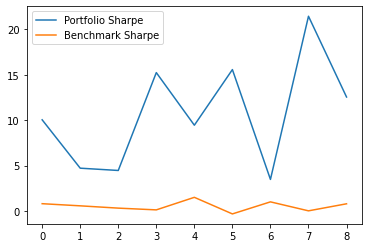

In [ ]:
#TT.plot_returns(portfolio_returns, benchmark_returns)
TT.plot_returns(portfolio_sharpe, benchmark_sharpe, returns=False)

In [ ]:
x = df_predictions
x.to_csv(path_or_buf='/content/gdrive/MyDrive/data/output_df_0303_1.csv')
